In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.linear_model import LinearRegression as LR, Ridge, Lasso
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split as tts

In [3]:
def do_Kfold(model,X,y,k,scaler = None, random_state = 146):
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k, random_state = random_state, shuffle=True)

    train_scores = []
    test_scores = []

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain, :]
        Xtest = X[idxTest, :]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
    return train_scores, test_scores

## Creating a regression problem with sklearn

In [4]:
from sklearn.datasets import make_regression

In [5]:
X,y = make_regression(n_samples = 200, n_features = 10, n_informative = 6, noise = 50, bias = 5, random_state = 201)

In [8]:
total_df = pd.DataFrame(X)
total_df['y'] = y
total_df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,0.211339,1.306702,-0.582700,2.238501,-1.887631,0.304063,-0.877961,-0.768607,-0.202263,-0.935555,-79.066327
1,-0.435640,0.930327,-1.447168,-0.341624,-0.090333,0.139289,-0.719006,-0.056696,-0.953587,-1.032692,-77.789517
2,-0.188300,1.710034,-1.163475,0.020111,-0.739641,0.696022,-0.300163,0.458113,-0.929149,0.565605,186.977067
3,-0.631271,-1.071740,-0.032026,0.031559,0.873978,0.244772,-1.909917,1.205834,-1.469368,-0.396660,22.104224
4,0.289950,-0.477053,-0.888612,0.531240,1.478253,0.800751,0.211970,1.234987,-1.761521,-0.679625,55.433829


/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


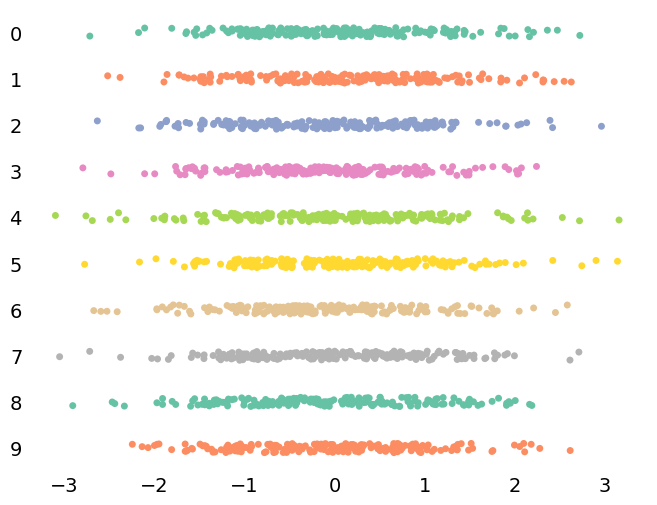

In [9]:
plt.figure(figsize = [8,6])
sns.stripplot(data = total_df.drop(columns = ['y']), orient = 'h', palette = 'Set2')
ax = plt.gca()
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.tick_params(size = 0, labelsize = 14)
plt.show()

In [19]:
trL, teL = do_Kfold(LR(), X, y, k = 10)  #what happens with k = 5 

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


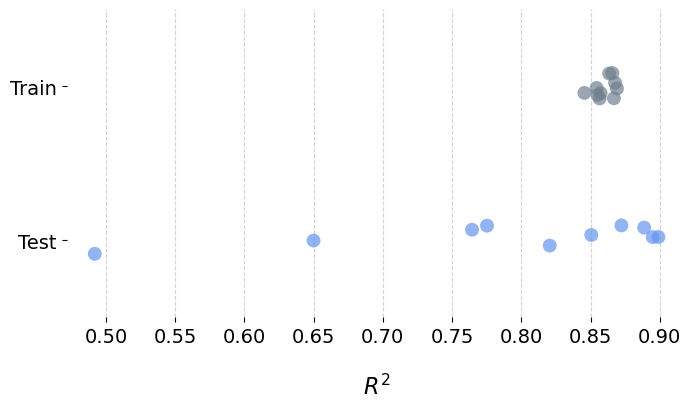

Average for train: 0.8602019489909306
Average for test: 0.7907467333215882


In [20]:
plt.figure(figsize = [8,4])
scores = pd.DataFrame(columns = ['Train','Test'])
scores['Train'] = trL
scores['Test'] = teL
ax = sns.stripplot(data = scores, orient = 'h', s = 10, alpha = 0.7,  
                   palette=['slategrey','cornflowerblue'])
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.grid(axis = 'x', linestyle = '--', color = 'lightgrey')
plt.tick_params(labelsize = 14)
plt.xlabel('$R^2$', fontsize = 16, labelpad = 20)
plt.show()
print(f'Average for train: {np.mean(trL)}')
print(f'Average for test: {np.mean (teL)}')

In [25]:
Xtrain,Xtest,ytrain,ytest = tts(X,y,train_size = 0.6, shuffle = True, random_state = 201) 
ss = SS()
Xtrain_s = ss.fit_transform(Xtrain)
Xtest_s = ss.transform(Xtest)

In [26]:
#Do OLS
lin_reg = LR()
lin_reg.fit(Xtrain_s, ytrain)
lin_reg.score(Xtrain_s, ytrain)

0.8607438425448656

In [28]:
#Score on test
lin_reg.score(Xtest_s, ytest)

0.8369383687477303

In [29]:
#Look at coef
lin_reg.coef_

array([50.39800559, -1.82284896, -2.92820334,  9.69730187, -2.56361878,
       73.9825787 ,  7.93713686, 59.62712808, -1.81760676, 65.25690375])

In [32]:
#Lasso
#find optimal alpha for Lasso
a_range = np.linspace(1,10,100) #start with 0.01 to 1
k = 10
#ss = SS()

avg_tr_score=[]
avg_te_score=[]

for a in a_range:
    las_reg = Lasso(alpha=a)
    train_scores, test_scores = do_Kfold(las_reg, X, y, k, SS())
    
    avg_tr_score.append(np.mean(train_scores))
    avg_te_score.append(np.mean(test_scores))

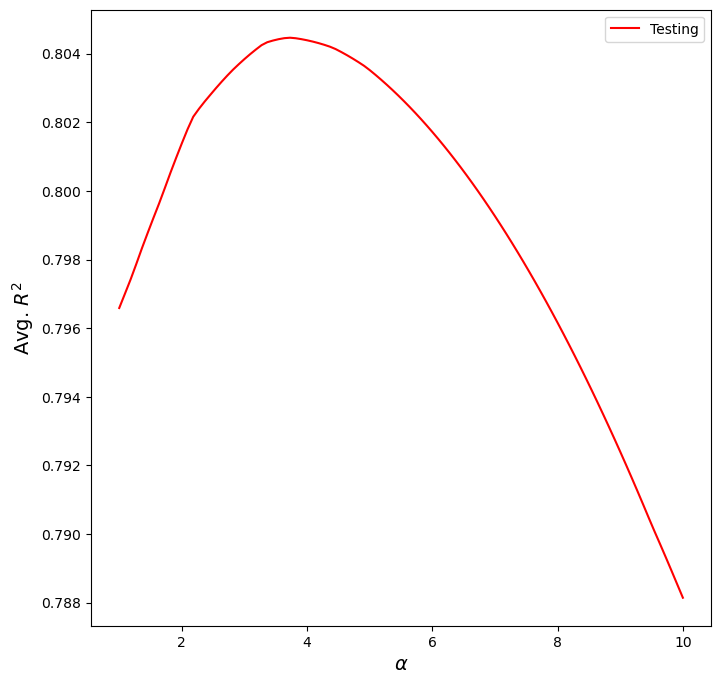

Optimal alpha in the range tested:  3.7272727272727275
Avg. training score at this value:  0.8553414342415397
Avg. testing score at this value:  0.8044652230897336


In [33]:
#look for vars that are collinear
#vars assoc with target and each other - which vars do we KNOW are assoc
#let's do OLS first
#we will get a single tts
plt.figure(figsize=(8,8))
#plt.plot(a_range, avg_tr_score, color='k', label='Training')
plt.plot(a_range, avg_te_score, color='r', label='Testing')
plt.xlabel('$\\alpha$', fontsize=14)
plt.ylabel('Avg. $R^2$', fontsize=14)
plt.legend()
plt.show()
idx_max = np.argmax(avg_te_score)

print('Optimal alpha in the range tested: ', a_range[idx_max])
print('Avg. training score at this value: ', avg_tr_score[idx_max])
print('Avg. testing score at this value: ', avg_te_score[idx_max])

In [34]:
#do Lasso regression on single tts
las_reg = Lasso(alpha = a_range[idx_max])
las_reg.fit(Xtrain_s, ytrain)
las_reg.score(Xtrain_s, ytrain)
#train decreased

0.8548075264868884

In [35]:
las_reg.score(Xtest_s, ytest)
#test increased

0.849299105556767

In [36]:
las_reg.coef_

array([46.43790921, -0.        , -0.        ,  5.21683154, -0.        ,
       70.23466155,  5.16409979, 55.58630273, -0.        , 60.13125614])

## sklearn available data sets

In [38]:
from sklearn.datasets import load_diabetes

In [39]:
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes
data = load_diabetes()

In [40]:
print(type(data))

<class 'sklearn.utils._bunch.Bunch'>


In [41]:
print(data)

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990749, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06833155, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286131, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04688253,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452873, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00422151,  0.00306441]]), 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
  

In [42]:
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [43]:
X = data.data
X_names = data.feature_names
X_df = pd.DataFrame(X, columns = X_names[0:4]+['tc','ldl','hdl','tch','ltg','glu'])

In [44]:
X_df.head()

,age,sex,bmi,bp,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [45]:
y = data.target

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


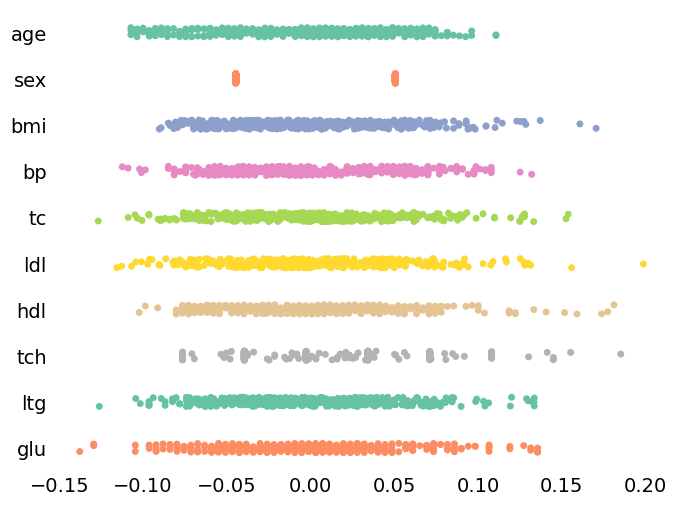

In [46]:
plt.figure(figsize = [8,6])
sns.stripplot(data = X_df, orient = 'h', palette = 'Set2')
ax = plt.gca()
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.tick_params(size = 0, labelsize = 14)
plt.show()